In [125]:
import json
import pickle
from tqdm import tqdm
import streamlit as st
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

DIR = "./test/"
model_path = './model_train_epoch_10.pth'
TEST_PKL = './test_paired_dict.pkl'
VAL_PKL = './val_paired_dict.pkl'
MLB_PKL = './mlb.pkl'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
THRESHOLD = 0.35

In [126]:
def get_img_path(img_id):
    
    img_path = DIR + [*img_id][0] + '/' + [*img_id][1] + '/' + [*img_id][2] + '/' + [*img_id][3] + '/' + img_id
    return img_path

In [127]:
class MyDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
    
    def __len__(self):
        return len(self.data_dict)
    
    def __getitem__(self, idx):
        image_id, ingredients = [*self.data_dict.items()][idx]
        image_path = get_img_path(image_id)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        ingredients_tensor = torch.tensor(ingredients)
        return image, ingredients_tensor

In [128]:
class ImgData(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
    
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        image_path = self.img_path
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [129]:
num_unique_ingredients = 440

model = models.resnet50(pretrained=True)
num_in_features = model.fc.in_features
model.fc = nn.Linear(num_in_features, num_unique_ingredients)
model.load_state_dict(torch.load(model_path))

criterion = nn.BCEWithLogitsLoss()


model.to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Helin\anaconda3\envs\hlcv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [130]:
with open(TEST_PKL, 'rb') as file:    
    test_paired_dict = pickle.load(file)
with open(VAL_PKL, 'rb') as file:
    val_paired_dict = pickle.load(file)

with open(MLB_PKL, 'rb') as file:
    mlb = pickle.load(file)


test_set = MyDataset(test_paired_dict, transform=preprocess)
val_set = MyDataset(val_paired_dict, transform=preprocess)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [131]:
def calc_scores(targets_idx, pred_idx):
    accuracy = []
    precision = []
    recall = []
    f1 = []
            
    for a,b in zip(targets_idx, pred_idx):
        targets_label = set(mlb.classes_[a])
        pred_label = set(mlb.classes_[b])
        intersection = targets_label.intersection(pred_label)
        pred_only = pred_label - intersection
        target_only = targets_label - intersection
        tp = len(intersection)
        fp = len(pred_only)
        fn = len(target_only)
        tn = num_unique_ingredients - (tp + fp + fn)
        accuracy.append((tp + tn) / (tp + fp + fn + tn))
        precision.append(tp / (tp + fp) if tp + fp != 0 else 0)
        recall.append(tp / (tp + fn) if tp + fn != 0 else 0)
        f1.append(2 * tp / (2 * tp + fp + fn) if tp + fp + fn != 0 else 0)
    return np.average(accuracy), np.average(precision), np.average(recall), np.average(f1)

In [137]:
def val_test(data_set, batch_size=BATCH_SIZE, threshold = THRESHOLD):
        
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0

    acc_ls = []
    pre_ls = []
    rec_ls = []
    f1_ls = []
    val_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=False, drop_last=True)
    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        
        with tqdm(val_loader, desc=f'Validation', unit='batch') as tqdm_loader:
            for val_data in tqdm_loader:
                val_inputs, val_labels = val_data
                
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device).float()
                

                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                
                val_outputs = torch.sigmoid(val_outputs)
                values = val_outputs.cpu().view(-1).numpy()
                
                
                plt.figure(figsize=(8, 6))
                plt.hist(values, bins=50, color='blue', alpha=0.7)
                plt.title('Distribution of Tensor Values')
                plt.xlabel('Value')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.savefig('./distribution.png')
                plt.show()
                

                
                targets_idx = [[idx for idx, col in enumerate(row) if col == 1] for row in val_labels.cpu()]
                pred_idx = [[idx for idx, col in enumerate(row) if col >= threshold] for row in val_outputs.cpu()]
                
                avg_accuracy, avg_precision, avg_recall, avg_f1 = calc_scores(targets_idx, pred_idx)
                acc_ls.append(avg_accuracy)
                pre_ls.append(avg_precision)
                rec_ls.append(avg_recall)
                f1_ls.append(avg_f1)
                
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                unnormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
                unnormalized_img_tensor = unnormalize(val_inputs)[0]
                unnormalized_tensor = torch.clamp(unnormalized_img_tensor, 0, 1)
                to_pil = transforms.ToPILImage()
                #image = to_pil(unnormalized_tensor) 
                #plt.axis('off')
                #plt.imshow(image)
                
                tqdm_loader.set_postfix(accuracy=avg_accuracy, precision=avg_precision, recall=avg_recall, f1=avg_f1)

    accuracy = np.average(acc_ls) 
    precision = np.average(pre_ls)
    recall = np.average(rec_ls)
    f1 = np.average(f1_ls)

    #print(f"Validation Loss: {val_loss}, Accuracy: {val_accuracy}%")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, Threshold: {threshold}")

In [133]:
def test(img_path, batch_size=1, threshold =THRESHOLD):
    test_loader = DataLoader(ImgData(img_path, transform=preprocess), batch_size=1)
    for test_data in test_loader:
        test_inputs = test_data
        test_inputs = test_inputs.to(device)
        test_outputs = model(test_inputs)
        test_outputs = torch.sigmoid(test_outputs)
        targets_idx = [[idx for idx, col in enumerate(row) if col >= threshold] for row in test_outputs.cpu()]
        return [mlb.classes_[idx] for idx in targets_idx[0]]

Validation:   0%|          | 0/814 [00:00<?, ?batch/s]

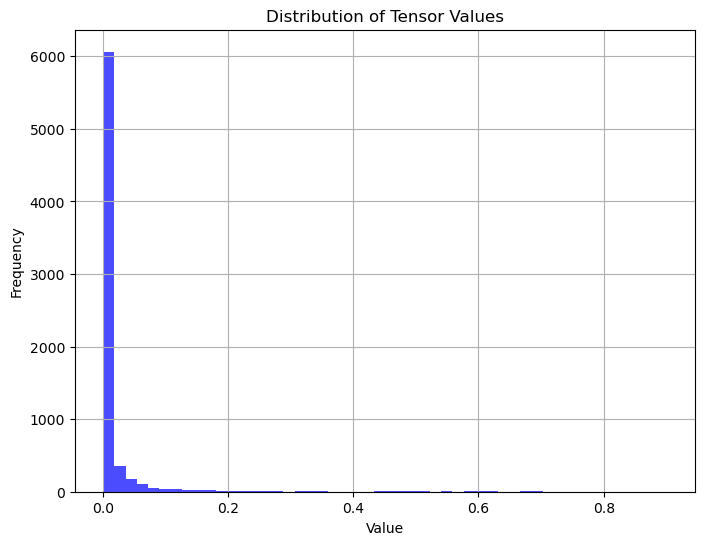

Validation:   0%|          | 1/814 [00:01<14:47,  1.09s/batch, accuracy=0.965, f1=0.345, precision=0.256, recall=0.617]

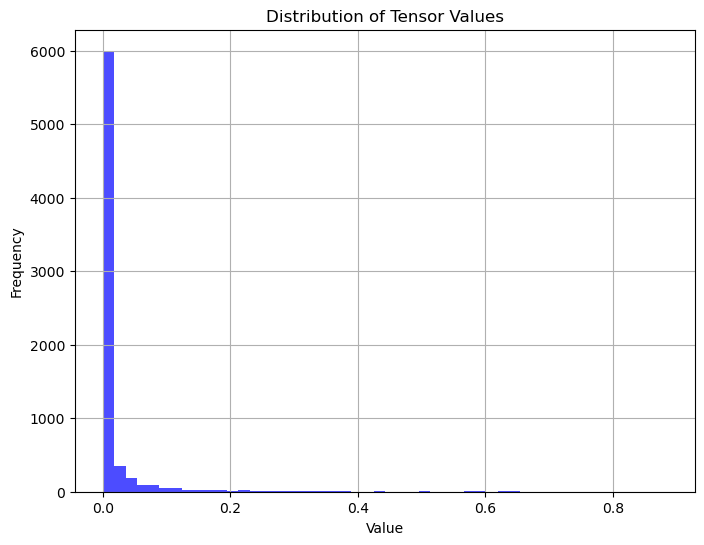

Validation:   0%|          | 2/814 [00:02<14:00,  1.03s/batch, accuracy=0.962, f1=0.387, precision=0.305, recall=0.611]

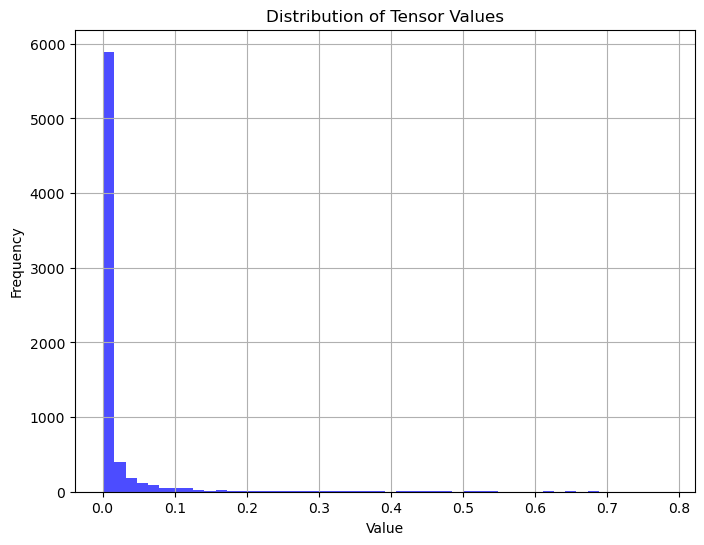

Validation:   0%|          | 3/814 [00:02<11:24,  1.18batch/s, accuracy=0.96, f1=0.295, precision=0.214, recall=0.515] 

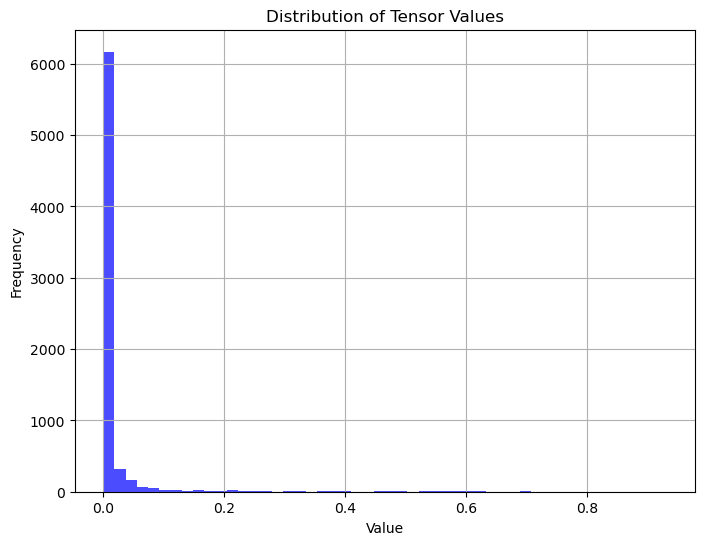

Validation:   0%|          | 4/814 [00:03<10:02,  1.34batch/s, accuracy=0.972, f1=0.55, precision=0.451, recall=0.725]

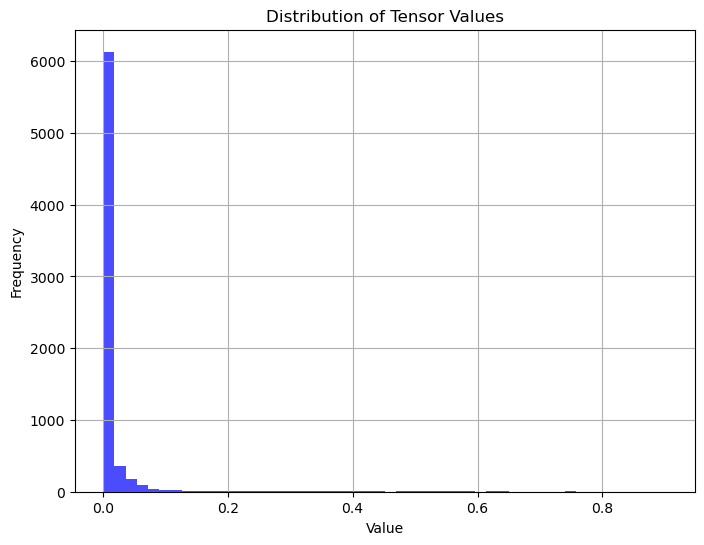

Validation:   1%|          | 5/814 [00:04<11:09,  1.21batch/s, accuracy=0.98, f1=0.615, precision=0.484, recall=0.852]


KeyboardInterrupt: 

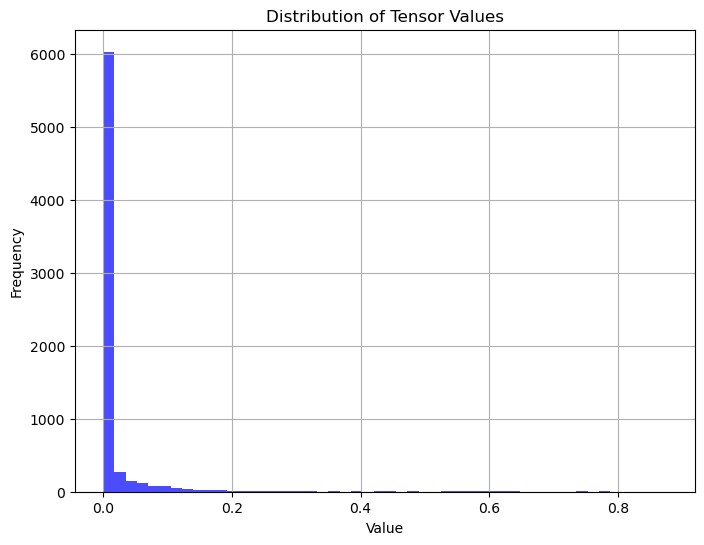

In [138]:
threshold_values = [0.1 + i * 0.05 for i in range(11)]
for thv in threshold_values:
    val_test(val_set, threshold=thv)

Validation: 100%|██████████| 849/849 [07:50<00:00,  1.81batch/s, accuracy=0.965, f1=0.249, precision=0.182, recall=0.458] 


Accuracy: 0.9674925045508084, Precision: 0.31574709254419503, Recall: 0.666111580317731, F1: 0.4125164340069897, Threshold: 0.1


Validation: 100%|██████████| 849/849 [06:39<00:00,  2.13batch/s, accuracy=0.973, f1=0.258, precision=0.215, recall=0.377]


Accuracy: 0.9761843813577471, Precision: 0.38772623484486113, Recall: 0.5894730296791841, F1: 0.4496095589089808, Threshold: 0.15000000000000002


Validation: 100%|██████████| 849/849 [06:41<00:00,  2.11batch/s, accuracy=0.978, f1=0.262, precision=0.307, recall=0.306]


Accuracy: 0.9802203795909625, Precision: 0.44566384172225093, Recall: 0.5264743637987822, F1: 0.4615550401639303, Threshold: 0.2


Validation: 100%|██████████| 849/849 [06:42<00:00,  2.11batch/s, accuracy=0.981, f1=0.267, precision=0.389, recall=0.274] 


Accuracy: 0.9824057714958775, Precision: 0.4924385736057556, Recall: 0.47164102791062673, F1: 0.45803696388554394, Threshold: 0.25


Validation: 100%|██████████| 849/849 [06:52<00:00,  2.06batch/s, accuracy=0.983, f1=0.25, precision=0.393, recall=0.227]   


Accuracy: 0.9835750950315879, Precision: 0.5264665144026893, Recall: 0.4218982458863368, F1: 0.44277518731098753, Threshold: 0.30000000000000004


Validation: 100%|██████████| 849/849 [07:23<00:00,  1.91batch/s, accuracy=0.984, f1=0.25, precision=0.41, recall=0.211]     


Accuracy: 0.984189454170682, Precision: 0.5517995122842738, Recall: 0.37492761480110764, F1: 0.41932165259672416, Threshold: 0.35


Validation: 100%|██████████| 849/849 [06:47<00:00,  2.09batch/s, accuracy=0.985, f1=0.242, precision=0.41, recall=0.2]      


Accuracy: 0.9844502891101832, Precision: 0.5666237983486216, Recall: 0.33002255066392183, F1: 0.38907679750082225, Threshold: 0.4


Validation: 100%|██████████| 849/849 [06:47<00:00,  2.08batch/s, accuracy=0.986, f1=0.215, precision=0.389, recall=0.165]   


Accuracy: 0.9844783970446515, Precision: 0.5663581990823598, Recall: 0.28434239546670725, F1: 0.35135993326835047, Threshold: 0.45000000000000007


Validation: 100%|██████████| 849/849 [06:51<00:00,  2.06batch/s, accuracy=0.986, f1=0.19, precision=0.378, recall=0.136]    


Accuracy: 0.9844022713887995, Precision: 0.5524919898760446, Recall: 0.23973518532123925, F1: 0.3091993591224825, Threshold: 0.5


Validation: 100%|██████████| 849/849 [06:54<00:00,  2.05batch/s, accuracy=0.986, f1=0.114, precision=0.281, recall=0.0719]  


Accuracy: 0.9841902907163508, Precision: 0.5186771727242133, Recall: 0.19479179075484823, F1: 0.26173095668203156, Threshold: 0.55


Validation: 100%|██████████| 849/849 [06:55<00:00,  2.04batch/s, accuracy=0.986, f1=0.0417, precision=0.125, recall=0.025]  


Accuracy: 0.9838953247135668, Precision: 0.4663739553536373, Recall: 0.15048813922666882, F1: 0.2106546750280384, Threshold: 0.6


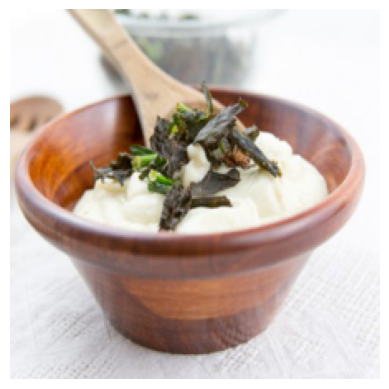

In [85]:
threshold_values = [0.1 + i * 0.05 for i in range(11)]
for thv in threshold_values:
    val_test(test_set, threshold=thv)

In [124]:
test_img = "./test_image.jpg"
labels = test(test_img, batch_size=BATCH_SIZE, threshold =THRESHOLD)
label_string = ", ".join(labels)
print(f"The food in the image contains: {label_string}")

The food in the image contains: egg, flour, sugar, vanilla


In [ ]:
#on validation, batchsize = 16
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
precision_scores = [0.32, 0.39, 0.42, 0.47, 0.52, 0.54, 0.56, 0.56, 0.55, 0.48, 0.28]
recall_scores = [0.65, 0.57, 0.50, 0.44, 0.40, 0.35, 0.31, 0.27, 0.22, 0.18, 0.06]
f1_scores = [0.41, 0.46, 0.45, 0.45, 0.42, 0.40, 0.37, 0.33, 0.29, 0.25, 0.10]

plt.figure(figsize=(10, 6))

plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores, marker='s', label='Recall')
plt.plot(thresholds, f1_scores, marker='d', label='F1 Score')

plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(thresholds)
plt.savefig('./val_scores.png')

plt.show()


In [ ]:
#test, batchsize = 16
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
precision = [0.316, 0.388, 0.446, 0.492, 0.526, 0.552, 0.567, 0.566, 0.552, 0.519, 0.466]
recall = [0.666, 0.589, 0.526, 0.472, 0.422, 0.375, 0.330, 0.284, 0.240, 0.195, 0.150]
f1_score = [0.413, 0.450, 0.462, 0.458, 0.443, 0.419, 0.389, 0.351, 0.310, 0.262, 0.211]